# data split


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [2]:
path = './data/'
newtrain = pd.read_csv(path+'train_user_count.csv')

print(newtrain.shape)


(306795, 5)


In [3]:
alrtrain = newtrain[newtrain["count"]!=1]
newtrain1 = newtrain[newtrain["count"]==1]

alrtrain.shape


(272178, 5)

In [4]:
new_test, new_valid, newy_test, newy_valid = train_test_split(
                                                        newtrain1.drop(['rating'], axis=1),
                                                        newtrain1['rating'],
                                                        test_size=0.5,
                                                        random_state=42, # args.SEED
                                                        shuffle=True
                                                        )

In [5]:
print(new_test.shape)
print(new_valid.shape)

(17308, 4)
(17309, 4)


In [6]:
# 66.66 : 11.66 : 11.66

alr_train, alr_valid, alry_train, alry_valid = train_test_split(
                                                        alrtrain.drop(['rating'], axis=1),
                                                        alrtrain['rating'],
                                                        test_size = 0.26,
                                                        random_state=42, # args.SEED
                                                        shuffle=True
                                                        )

In [7]:
alr_test, alr_valid, alry_test, alry_valid = train_test_split(
                                                        alr_valid,
                                                        alry_valid,
                                                        test_size = 0.5,
                                                        random_state=42, # args.SEED
                                                        shuffle=True
                                                        )

In [8]:
print(alr_train.shape)
print(alr_valid.shape)
print(alr_test.shape)

(201411, 4)
(35384, 4)
(35383, 4)


# data annalysis


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [37]:

def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6

def process_context_data(users, books, ratings1, ratings2):
    users['location_city'] = users['location'].apply(lambda x: x.split(',')[0])
    users['location_state'] = users['location'].apply(lambda x: x.split(',')[1])
    users['location_country'] = users['location'].apply(lambda x: x.split(',')[2])
    users = users.drop(['location'], axis=1)

    ratings = pd.concat([ratings1, ratings2]).reset_index(drop=True)

    # 인덱싱 처리된 데이터 조인
    context_df = ratings.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    train_df = ratings1.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')
    test_df = ratings2.merge(users, on='user_id', how='left').merge(books[['isbn', 'category', 'publisher', 'language', 'book_author']], on='isbn', how='left')

    # 인덱싱 처리
    loc_city2idx = {v:k for k,v in enumerate(context_df['location_city'].unique())}
    loc_state2idx = {v:k for k,v in enumerate(context_df['location_state'].unique())}
    loc_country2idx = {v:k for k,v in enumerate(context_df['location_country'].unique())}

    train_df['location_city'] = train_df['location_city'].map(loc_city2idx)
    train_df['location_state'] = train_df['location_state'].map(loc_state2idx)
    train_df['location_country'] = train_df['location_country'].map(loc_country2idx)
    test_df['location_city'] = test_df['location_city'].map(loc_city2idx)
    test_df['location_state'] = test_df['location_state'].map(loc_state2idx)
    test_df['location_country'] = test_df['location_country'].map(loc_country2idx)

    train_df['age'] = train_df['age'].fillna(int(train_df['age'].mean()))
    train_df['age'] = train_df['age'].apply(age_map)
    test_df['age'] = test_df['age'].fillna(int(test_df['age'].mean()))
    test_df['age'] = test_df['age'].apply(age_map)

    # book 파트 인덱싱
    category2idx = {v:k for k,v in enumerate(context_df['category'].unique())}
    publisher2idx = {v:k for k,v in enumerate(context_df['publisher'].unique())}
    language2idx = {v:k for k,v in enumerate(context_df['language'].unique())}
    author2idx = {v:k for k,v in enumerate(context_df['book_author'].unique())}

    train_df['category'] = train_df['category'].map(category2idx)
    train_df['publisher'] = train_df['publisher'].map(publisher2idx)
    train_df['language'] = train_df['language'].map(language2idx)
    train_df['book_author'] = train_df['book_author'].map(author2idx)
    test_df['category'] = test_df['category'].map(category2idx)
    test_df['publisher'] = test_df['publisher'].map(publisher2idx)
    test_df['language'] = test_df['language'].map(language2idx)
    test_df['book_author'] = test_df['book_author'].map(author2idx)

    idx = {
        "loc_city2idx":loc_city2idx,
        "loc_state2idx":loc_state2idx,
        "loc_country2idx":loc_country2idx,
        "category2idx":category2idx,
        "publisher2idx":publisher2idx,
        "language2idx":language2idx,
        "author2idx":author2idx,
    }

    return idx, train_df, test_df


In [38]:
path = './data/'

users = pd.read_csv(path + 'users.csv')
books = pd.read_csv(path + 'books.csv')
train = pd.read_csv(path + 'train_ratings.csv')
test = pd.read_csv(path + 'test_ratings.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

ids = pd.concat([train['user_id'], sub['user_id']]).unique()
isbns = pd.concat([train['isbn'], sub['isbn']]).unique()

idx2user = {idx:id for idx, id in enumerate(ids)}
idx2isbn = {idx:isbn for idx, isbn in enumerate(isbns)}

user2idx = {id:idx for idx, id in idx2user.items()}
isbn2idx = {isbn:idx for idx, isbn in idx2isbn.items()}

train['user_id'] = train['user_id'].map(user2idx)
sub['user_id'] = sub['user_id'].map(user2idx)
test['user_id'] = test['user_id'].map(user2idx)
users['user_id'] = users['user_id'].map(user2idx)

train['isbn'] = train['isbn'].map(isbn2idx)
sub['isbn'] = sub['isbn'].map(isbn2idx)
test['isbn'] = test['isbn'].map(isbn2idx)
books['isbn'] = books['isbn'].map(isbn2idx)

idx, context_train, context_test = process_context_data(users, books, train, test)

In [39]:
train.head(30)

,user_id,isbn,rating
0,0,0,4
1,1,0,7
2,2,0,8
3,3,0,8
4,4,0,9
5,5,0,7
6,6,0,5
7,7,1,8
8,8,2,6
9,9,2,10


In [40]:
train[train["count_y"]==1]["rating"].std()

KeyError: 'count_y'

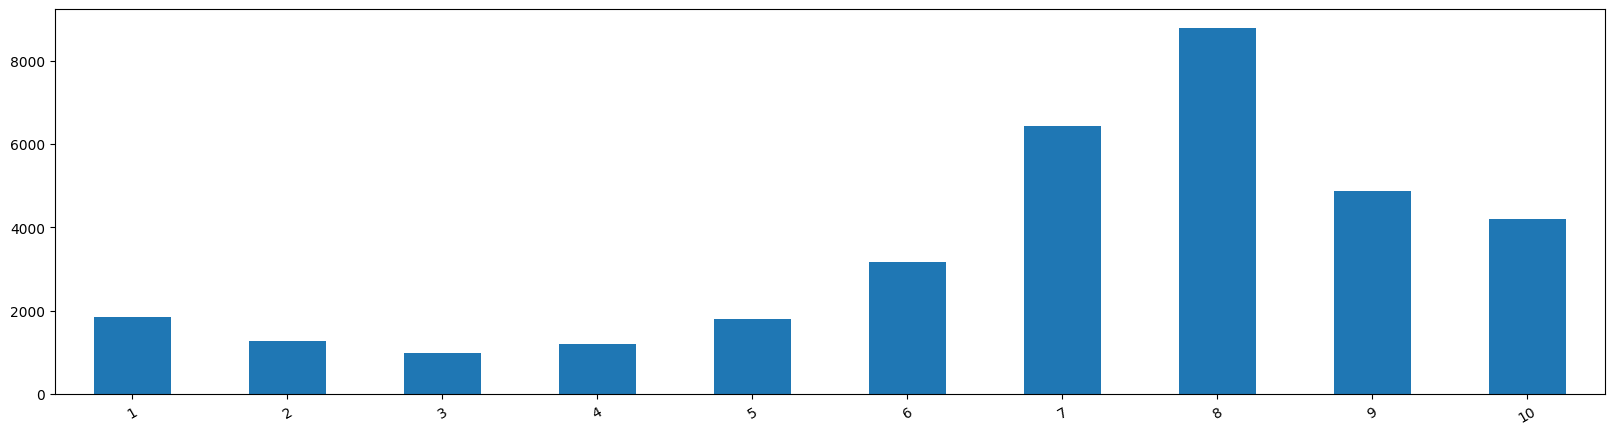

In [ ]:
plt.figure(figsize=(20,5))
train[train["count_y"]==1]["rating"].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()


In [41]:
test.head(30)

,user_id,isbn,rating
0,13,0,0
1,13426,0,0
2,26761,1,0
3,16495,2,0
4,6225,3,0
5,6900,3,0
6,3087,3,0
7,13,129777,0
8,59803,9,0
9,9776,12,0


In [42]:
count=test.groupby("user_id").size()
dfcount = pd.DataFrame(count, columns=["count"])
test=test.merge(dfcount,on="user_id")
test=test[1::]
alrtrain = test[test["count"]!=1].drop(['count'],axis=1)
newtrain = test[test["count"]==1].drop(['count'],axis=1)

In [43]:
newtrain.count()

user_id    16785
isbn       16785
rating     16785
dtype: int64

In [44]:
newtrain.head(30)

,user_id,isbn,rating
1433,16495,2,0
1472,59803,9,0
1484,59804,13,0
1530,15317,13,0
1531,12337,13,0
1595,59805,13,0
1598,59806,13,0
1599,59807,13,0
1600,59808,13,0
1604,59809,13,0


# 7 때려박기


In [3]:
import time


submission = pd.read_csv('./submit/20221024_130422_FM-20221025_022157_DeepCoNN-mixed.csv')

# submission = pd.read_csv('./data/sample_submission.csv')
train1 = pd.read_csv('./data/train_ratings.csv')


count=train1.groupby("user_id").size()
dfcount = pd.DataFrame(count, columns=["count"])
submission=pd.merge(submission,dfcount, how='left', on='user_id')
submission['count'] = submission['count'].fillna(0)
submission.set_index("user_id",inplace = True)

for row in submission.itertuples():
    if row[3] == 0 :
        submission.at[row[0],"rating"] = 8

submission = submission.reset_index()
submission = submission.drop(['count'], axis=1)


now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')
submission.to_csv('submit/{}_{}.csv'.format(save_time, "FM_DCN"), index=False)